### Sin 함수를 예측할 수 있는지 실습으로 알아보자! 

#### Generate Dataset

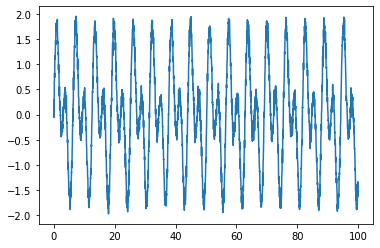

In [125]:
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


# ====== Generating Dataset ====== #
num_data = 2400
t = np.linspace(0, 100,num_data)
y = np.sin(t) + np.sin(2*t)
e = np.random.normal(0, 0.1, num_data)
y=y+e

#plt.plot(t,y)

seq_len = 10   #10개를 보여준다
X=[]
y_true=[]
for i in range(len(t)-seq_len):
  X.append(y[i:i+seq_len])
  y_true.append(y[i+seq_len])

# [10, 2390, 1] 이렇게 바꾸고 싶다 

X=np.array(X)
y_true = np.array(true_y)

X = np.swapaxes(X,0,1)  #(2390,10) -> (10,2390)
X = np.expand_dims(X, axis=2) #(10,2390) - > (10,2390,1)

#print(x.shape)  = (10, 2390, 1) 
#이렇게 만들어 놓으면 스텝별로 진행할 때 for문 돌리기 편하다

plt.plot(t, y)

목표는 이 함수를 완벽하게 fitting 하는 걸로 잡고 진행

#### Model Define


In [126]:
#최근 10개의 값을 보여주고 다음 값을 예측하는 모델을 만들 것 
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_size): 
      super(RNN, self).__init__()

      self.input_dim = input_dim
      self.hid_dim = hid_dim
      self.out_dim = output_dim
      self.batch_size = batch_size

      self.u = nn.Linear(self.input_dim,self.hid_dim,bias= False)
      self.w = nn.Linear(self.hid_dim,self.hid_dim,bias= False)
      self.v = nn.Linear(self.hid_dim,self.out_dim,bias= False)
      self.act = nn.Tanh()

      self.hidden = self.init_hidden()

    def init_hidden(self,batch_size=None):
      if batch_size is None:
        batch_size = self.batch_size
      return torch.zeros(self.batch_size, self.hid_dim)

    def forward(self,x):
      h = self.u(x) + self.w(self.hidden)
      h = self.act(h)
      y = self.v(h)

      return y,h 


#### **Train Trigonometric Function**

In [127]:
import torch.optim as optim

model = RNN(1,1, 10 ,2390)
optimizer = optim.SGD(model.parameters(),lr = 0.01)
loss_fn = nn.MSELoss()
epoch = 100

# print(model.hidden) = tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


#========= Train ===========#



print(X.shape)
for i in range(epoch):
  model.train()
  model.zero_grad()
  optimizer.zero_grad()

  model.hidden = model.init_hidden()  #epoch이 돌 때마다 hidden dimention을 초기화 

  for x in X : 
    x = torch.Tensor(x).float()
    y_true = torch.Tensor(y_true).float()
    y_pred,hidden  = model(x)
    model.hidden = hidden

  loss = loss_fn(y_pred.view(-1),y_true.view(-1))
  loss.backward()
  optimizer.step()
  if i%10==0:
    print(loss.item())

(10, 2390, 1)
1.1515746116638184
0.5009492039680481
0.23090790212154388
0.12016420066356659
0.07632607221603394
0.059128254652023315
0.052011072635650635
0.048611924052238464
0.0466015599668026
0.045147668570280075


좀 더 정성적인 Validation을 해보자  
처음 10개의 데이터만 가지고 예측하게 하는 거지

In [137]:
test_X = np.expand_dims(X[:, 0, :], 1)

list_y_pred = []

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size=1)

    for x in test_X:
        x = torch.Tensor(x).float()
        y_pred, hidden = model(x)
        model.hidden = hidden
    list_y_pred.append(y_pred.view(-1).item())
    
    temp_X = list()
    temp_X += list(np.squeeze(test_X))[1:]
    temp_X.append(y_pred.view(-1).item())
    for i in range(2389):
        model.hidden = model.init_hidden(batch_size=1)
        
        temp2_X = torch.unsqueeze(torch.unsqueeze(torch.Tensor(temp_X), 1), 1)
        
        for x in temp2_X:
            y_pred, hidden = model(x)
            model.hidden = hidden
        list_y_pred.append(y_pred.view(-1).item())
        
        temp_X.append(y_pred.view(-1).item())
        temp_X.pop(0)

plt.plot(y, label='actual value')
plt.plot(list(range(10, 2400)), list_y_pred, '*', label='predicted')
plt.xlim(0, 40)
plt.legend()

ValueError: ignored